In [27]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [226]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    w = np.linalg.solve(tx.transpose() @ tx, tx.transpose() @ y)
    mse = 1/2/y.shape[0] * np.sum((y - tx@w)**2, axis=0)
    rmse = np.sqrt(2*mse)
    #np.linalg.inv was giving problems here, watch out!!
    return rmse, w

In [243]:
from helpers import *
height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)
# np.linalg.inv(tx.transpose() @ tx) @ tx.transpose() @ y

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [228]:
from helpers import *
from grad_descent_ex02 import *

def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    
    mse_ls, w_ls = least_squares(y,tx)
    
    mse_gd, w_gd = gradient_descent(y, tx, np.array([5, 10]), max_iters=50, gamma=0.2)
    
    print("\n", "Least Squares: ", (mse_ls, w_ls), "\n", "Gradient Descent: ", (mse_gd[-1], w_gd[-1]))
    #GD loss will be half the size due to 1/2 term (simply for convenience when taking derivative, does not change
    #optimization process)

Test it here

In [229]:
test_your_least_squares()

Gradient Descent(0/49): loss=2353.4699783987517, w0=18.658784400421034, w1=10.695942486997815
Gradient Descent(1/49): loss=1511.7597058079798, w0=29.585811920757834, w1=11.252696476596055
Gradient Descent(2/49): loss=973.065131349887, w0=38.327433937027294, w1=11.698099668274644
Gradient Descent(3/49): loss=628.3006036967067, w0=45.32073155004288, w1=12.054422221617513
Gradient Descent(4/49): loss=407.6513059986707, w0=50.91536964045533, w1=12.339480264291819
Gradient Descent(5/49): loss=266.43575547192813, w0=55.39108011278531, w1=12.56752669843126
Gradient Descent(6/49): loss=176.0578031348124, w0=58.97164849064929, w1=12.749963845742812
Gradient Descent(7/49): loss=118.21591363905853, w0=61.83610319294046, w1=12.895913563592057
Gradient Descent(8/49): loss=81.1971043617761, w0=64.1276669547734, w1=13.012673337871451
Gradient Descent(9/49): loss=57.50506642431533, w0=65.96091796423977, w1=13.106081157294971
Gradient Descent(10/49): loss=42.342162144340335, w0=67.42751877181286, w1=13

## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [247]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [248]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    x = np.tile(np.array(x), (degree+1, 1)).transpose()
    pwrs = np.arange(0, degree+1)
    x = x**pwrs
    return x

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [249]:
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        tx = build_poly(x, degree)
        
        rmse, weights = least_squares(y, tx)
        

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.25858277667737484
Processing 3th experiment, degree=7, rmse=0.24965870360907327
Processing 4th experiment, degree=12, rmse=0.24328247483727986


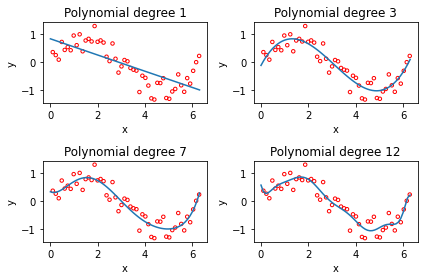

In [250]:
polynomial_regression()
#Best model seems to be 3rd order polynomial. Simplest model that fits the data and RMSE comparable to that of 7th and
# 12th order models

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [251]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    np.random.shuffle(x)
    np.random.shuffle(y)
    
    y_ind = int(ratio * len(y))
    x_ind = int(ratio * len(x))
    
    xtrain, ytrain = x[:x_ind], y[:y_ind]
    xtest, ytest = x[x_ind+1:], y[y_ind+1:]
    
    return (xtrain, ytrain), (xtest, ytest)

Then, test your `split_data` function below.

In [258]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    
    train_set, test_set = split_data(x, y, ratio)
    
    x_train = build_poly(train_set[0], degree)
    y_train = train_set[1]
    
    x_test = build_poly(test_set[0], degree)
    y_test = test_set[1]
    

    rmse_tr, w = least_squares(y_train, x_train)
    rmse_te = np.sqrt(1/y_test.shape[0] * np.sum((y_test - x_test@w)**2, axis=0))
    
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))
#     print(ratio)
#     print(degree)
#     print(rmse_te)
#     print(rmse_tr)


In [259]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.722, Testing RMSE=0.550
proportion=0.9, degree=3, Training RMSE=0.708, Testing RMSE=0.657
proportion=0.9, degree=7, Training RMSE=0.611, Testing RMSE=1.324
proportion=0.9, degree=12, Training RMSE=0.583, Testing RMSE=0.791
proportion=0.5, degree=1, Training RMSE=0.615, Testing RMSE=0.815
proportion=0.5, degree=3, Training RMSE=0.757, Testing RMSE=0.685
proportion=0.5, degree=7, Training RMSE=0.512, Testing RMSE=0.933
proportion=0.5, degree=12, Training RMSE=0.308, Testing RMSE=2.965
proportion=0.1, degree=1, Training RMSE=0.377, Testing RMSE=1.060
proportion=0.1, degree=3, Training RMSE=0.227, Testing RMSE=47.509
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=11.322
proportion=0.1, degree=12, Training RMSE=0.000, Testing RMSE=10.702


# 3 Ridge Regression
Please fill in the function below.

In [265]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    N = y.shape[0]
#     print('tx: ', tx.shape, '\n')
#     print('N: ', N, '\n')
    
    
    a = tx.transpose() @ tx + 2*N*lambda_*np.identity(tx.shape[1])
    b = tx.transpose() @ y
#     w = np.linalg.solve(a, b)
    w = np.linalg.inv(a) @ b
    
    mse = 1/2/N * np.sum((y - tx@w)**2, axis=0)
    rmse = np.sqrt(2*mse)
    
    return rmse, w

In [266]:
x_poly = build_poly(x, 7)

rmse_ls, w_ls = least_squares(y, x_poly)
rmse_r, w_r = ridge_regression(y, x_poly, 0)

print('rmse_ls: ', rmse_ls, 'w_ls: ', w_ls, '\n',
     'rmse_r: ', rmse_r, 'w_r: ', w_r)

rmse_ls:  0.6866042707173875 w_ls:  [-8.10860002e-01  4.28680520e+00 -7.51910083e+00  5.61726378e+00
 -2.13581591e+00  4.36205470e-01 -4.55749230e-02  1.90949906e-03] 
 rmse_r:  0.6866042707173784 w_r:  [-8.10859996e-01  4.28680519e+00 -7.51910083e+00  5.61726378e+00
 -2.13581591e+00  4.36205470e-01 -4.55749230e-02  1.90949906e-03]


In [267]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    
    train_set, test_set = split_data(x, y, ratio)
    
    x_train = build_poly(train_set[0], degree)
    y_train = train_set[1]
    
    x_test = build_poly(test_set[0], degree)
    y_test = test_set[1]

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        _rmse_tr, w = ridge_regression(y_train, x_train, lambda_)
        _rmse_te = np.sqrt(1/y_test.shape[0] * np.sum((y_test - x_test@w)**2, axis=0))
        
        rmse_tr.append(_rmse_tr)
        rmse_te.append(_rmse_te)
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)



proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.607, Testing RMSE=0.703
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.608, Testing RMSE=0.708
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.610, Testing RMSE=0.716
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.611, Testing RMSE=0.726
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.613, Testing RMSE=0.737
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.614, Testing RMSE=0.750
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.617, Testing RMSE=0.767
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.620, Testing RMSE=0.779
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.625, Testing RMSE=0.778
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.631, Testing RMSE=0.765
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.640, Testing RMSE=0.751
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.650, Testing RMSE=0.748
proportion=0.5, degree=7, lambda=0.193, 

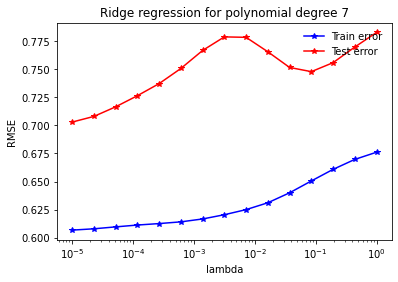

In [268]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)